In [2]:
%matplotlib inline

In [3]:
import pandas as pd
from pycaret.classification import *

In [5]:
from category_encoders.cat_boost import CatBoostEncoder

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
def converter(x):
    c, n = "", ""
    x = str(x).replace(".", "").replace("/", "").replace(" ", "")
    for i in x:
        if i.isnumeric():
            n += i
        else:
            c += i
    if n != "":
        return c, int(n)
    
    return c, np.nan

# feature engineering based on EDA
def create_extra_features(data):
    data["Ticket_type"] = data["Ticket"].map(lambda x: converter(x)[0])
    data["Ticket_number"] = data["Ticket"].map(lambda x: converter(x)[1])
    data["Cabin_type"] = data["Cabin"].map(lambda x: converter(x)[0])
    data["Cabin_number"] = data["Cabin"].map(lambda x: converter(x)[1])
    data["Name1"] = data["Name"].map(lambda x: x.split(", ")[0])
    data["Name2"] = data["Name"].map(lambda x: x.split(", ")[1])
    data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
    data["isAlone"] = data["FamilySize"].apply(lambda x: 1 if x==1 else 0)
    
    # Sex
    data["Sex"] = data["Sex"].map({"male": 0, "female": 1})
    
    # Age
    age_map = train[["Age", "Pclass"]].dropna().groupby("Pclass").median().to_dict()["Age"]
    data.loc[train["Age"].isnull(), "Age"] = data.loc[train["Age"].isnull(), "Pclass"].map(age_map)
    
    # Embarked
    data["Embarked"] = data["Embarked"].fillna("X")
    
    return data

train = create_extra_features(train)
test = create_extra_features(test)

In [14]:
train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

In [15]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_type,Ticket_number,Cabin_type,Cabin_number,Name1,Name2,FamilySize,isAlone
0,0,3,NaN,22.0,1,0,7.2500,S,A,521171.0,nan,NaN,Braund,Mr. Owen Harris,2,0
1,1,1,NaN,38.0,1,0,71.2833,C,PC,17599.0,C,85.0,Cumings,Mrs. John Bradley (Florence Briggs Thayer),2,0
2,1,3,NaN,26.0,0,0,7.9250,S,STONO,23101282.0,nan,NaN,Heikkinen,Miss. Laina,1,1
3,1,1,NaN,35.0,1,0,53.1000,S,,113803.0,C,123.0,Futrelle,Mrs. Jacques Heath (Lily May Peel),2,0
4,0,3,NaN,35.0,0,0,8.0500,S,,373450.0,nan,NaN,Allen,Mr. William Henry,1,1


In [16]:
from category_encoders.cat_boost import CatBoostEncoder

ce = CatBoostEncoder()

column_name = ["Ticket_type", "Embarked", "Cabin_type", "Name1", "Name2"]
train[column_name] = ce.fit_transform(train[column_name], train["Survived"])
test[column_name] = ce.transform(test[column_name])

In [17]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket_type,Ticket_number,Cabin_type,Cabin_number,Name1,Name2,FamilySize,isAlone
0,0,3,NaN,22.0,1,0,7.2500,0.383838,0.383838,521171.0,0.383838,NaN,0.383838,0.383838,2,0
1,1,1,NaN,38.0,1,0,71.2833,0.383838,0.383838,17599.0,0.383838,85.0,0.383838,0.383838,2,0
2,1,3,NaN,26.0,0,0,7.9250,0.191919,0.383838,23101282.0,0.191919,NaN,0.383838,0.383838,1,1
3,1,1,NaN,35.0,1,0,53.1000,0.461279,0.383838,113803.0,0.691919,123.0,0.383838,0.383838,2,0
4,0,3,NaN,35.0,0,0,8.0500,0.595960,0.691919,373450.0,0.461279,NaN,0.383838,0.383838,1,1


In [20]:
# setup AutoML Environment (PyCaret)

setup(data=train, 
      target="Survived", 
      numeric_imputation="median", 
      fold=5, 
      silent=True)

In [21]:
best_model = compare_models(sort="Accuracy", n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7416,0.0000,0.5404,0.7076,0.6124,0.4236,0.4327,0.0080
lda,Linear Discriminant Analysis,0.7368,0.7715,0.5489,0.6913,0.6117,0.4164,0.4230,0.0100
rf,Random Forest Classifier,0.7335,0.7762,0.5787,0.6703,0.6203,0.4170,0.4201,0.2460
et,Extra Trees Classifier,0.7318,0.7606,0.5830,0.6658,0.6194,0.4146,0.4180,0.2360
lightgbm,Light Gradient Boosting Machine,0.7174,0.7704,0.5617,0.6449,0.6000,0.3833,0.3857,0.0380
ada,Ada Boost Classifier,0.7062,0.7369,0.5617,0.6203,0.5888,0.3616,0.3630,0.0460
gbc,Gradient Boosting Classifier,0.6886,0.7403,0.5064,0.6069,0.5516,0.3159,0.3193,0.0540
knn,K Neighbors Classifier,0.6660,0.7050,0.5149,0.5571,0.5326,0.2748,0.2767,0.4120
lr,Logistic Regression,0.6404,0.6559,0.1021,0.7741,0.1431,0.0774,0.1362,0.5660
nb,Naive Bayes,0.6212,0.7060,0.0298,0.3857,0.0542,0.0112,0.0274,0.0100


In [25]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6880,0.7390,0.5532,0.5909,0.5714,0.3266,0.3270
1,0.7520,0.8292,0.6170,0.6905,0.6517,0.4601,0.4618
2,0.7440,0.7935,0.5745,0.6923,0.6279,0.4353,0.4398
3,0.7016,0.7201,0.5532,0.6190,0.5843,0.3527,0.3541
4,0.7016,0.7701,0.5106,0.6316,0.5647,0.3416,0.3460
Mean,0.7174,0.7704,0.5617,0.6449,0.6000,0.3833,0.3857
SD,0.0256,0.0388,0.0346,0.0402,0.0339,0.0539,0.0543


In [31]:
lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7200,0.7559,0.5745,0.6429,0.6067,0.3904,0.3919
1,0.7680,0.8273,0.6809,0.6957,0.6882,0.5035,0.5036
2,0.7600,0.7711,0.5957,0.7179,0.6512,0.4706,0.4754
3,0.6694,0.6960,0.5532,0.5652,0.5591,0.2947,0.2947
4,0.7339,0.7275,0.4681,0.7333,0.5714,0.3918,0.4126
Mean,0.7302,0.7556,0.5745,0.6710,0.6153,0.4102,0.4156
SD,0.0350,0.0441,0.0686,0.0611,0.0485,0.0727,0.0728


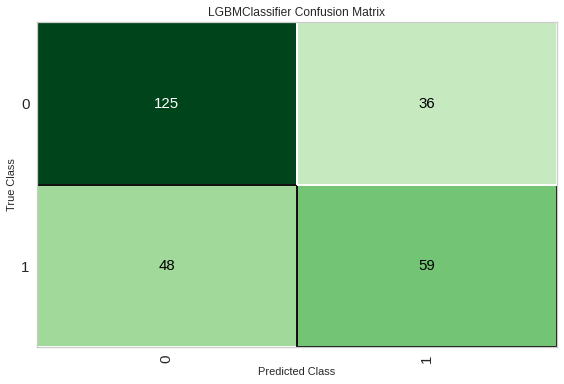

In [32]:
plot_model(lightgbm, plot="confusion_matrix")

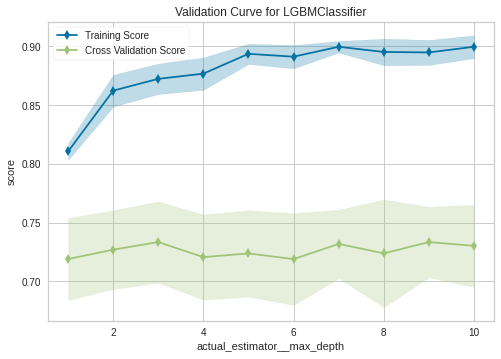

In [35]:
plot_model(lightgbm, plot="vc")

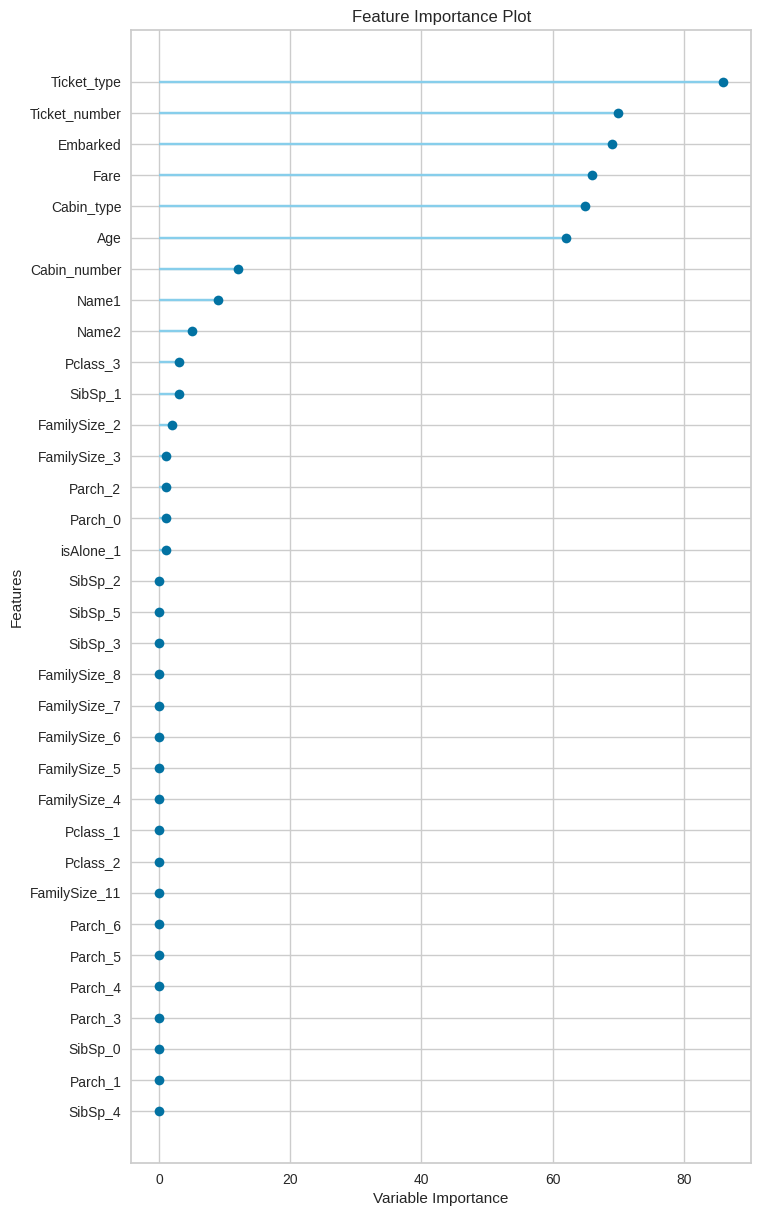

In [38]:
plot_model(lightgbm, plot="feature_all")

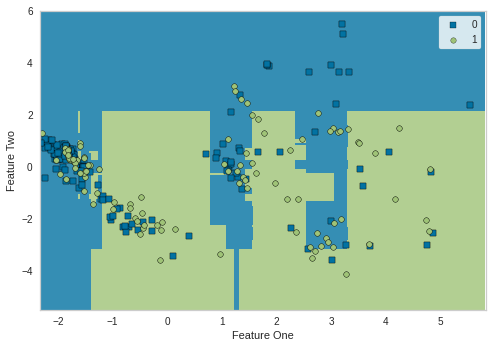

In [39]:
plot_model(lightgbm, plot = 'boundary')

In [47]:
lgbm_final = finalize_model(lightgbm)

In [48]:
y_pred_test = predict_model(lgbm_final, data=test)

In [65]:
a = np.int64(123)

import sys

sys.getsizeof(np.int64(11111111111111111))

32

In [69]:
32 * np.power(19, 10) / np.power(1024, 4)

178.43751288604108

In [73]:
32 * np.power(8, 10) / np.power(1024, 3)

32.0

In [42]:
lightgbm = create_model('lightgbm')
catboost = create_model('catboost')
best_models = [lightgbm, catboost]

blended = blend_models(estimator_list = best_models, fold=5, method="soft")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6880,0.7390,0.5532,0.5909,0.5714,0.3266,0.3270
1,0.7520,0.8292,0.6170,0.6905,0.6517,0.4601,0.4618
2,0.7440,0.7935,0.5745,0.6923,0.6279,0.4353,0.4398
3,0.7016,0.7201,0.5532,0.6190,0.5843,0.3527,0.3541
4,0.7016,0.7701,0.5106,0.6316,0.5647,0.3416,0.3460
Mean,0.7174,0.7704,0.5617,0.6449,0.6000,0.3833,0.3857
SD,0.0256,0.0388,0.0346,0.0402,0.0339,0.0539,0.0543


ValueError: Estimator catboost not available. Please see docstring for list of available estimators.